# Binary Classification. UCI Sentiment Labelled Sentences II

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn

import re
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords

print(f"Tensor Flow Version: {tf.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available." if gpu else "NOT AVAIALBLE!!!")
print(tf.config.list_physical_devices())

Tensor Flow Version: 2.8.0
GPU is available.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package punkt to /Users/Rho.l/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Rho.l/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# II Data Preparation

### Read the Data in.

In [2]:
colnames = ['review','is_positive']
raw = pd.read_csv('../data/uci_sentiment_lablelled_sentences/imdb_labelled.txt', sep=" \t", lineterminator="\n", names=colnames, engine='python', header=None)
raw

#engine='python' : The default 'c'- engine considers my sep value regex and will not parse it. 

,review,is_positive
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


### Exploratory Data Analysis [B1-2] 

In [3]:
# Unusual Character Discovery

reviews = raw.review
character_list = []
for review in reviews:
    for character in review:
        if character not in character_list:
            character_list.append(character)

print(character_list)

['A', ' ', 'v', 'e', 'r', 'y', ',', 's', 'l', 'o', 'w', '-', 'm', 'i', 'n', 'g', 'a', 'b', 'u', 't', 'd', 'f', '.', 'N', 'h', 'c', 'k', 'p', '&', 'x', 'V', 'T', 'G', 'I', "'", 'W', 'S', 'L', 'J', 'B', 'F', 'M', 'H', 'C', '"', '\x96', 'z', '?', 'q', 'Y', 'j', 'P', 'U', 'R', 'E', '1', '3', ';', '/', 'O', '2', '9', '0', ':', '*', 'D', 'Q', 'é', '(', ')', '!', 'K', '$', '7', '5', 'Z', '\x85', '8', '+', '%', '4', 'å', '6', '\x97', 'X']


In [4]:
review_list = []
stop_words = stopwords.words('english')
lemma = nltk.WordNetLemmatizer()

for description in raw.review:
    description = re.sub("[^a-zA-Z0-9]"," ",description)
    description = description.lower()
    description = nltk.word_tokenize(description)
    description = [lemma.lemmatize(word) for word in description]
    review_list.append(description)

(array([737., 238.,  21.,   4.,   0.]),
 array([  0,  20,  40,  60,  80, 100]),
 <BarContainer object of 5 artists>)

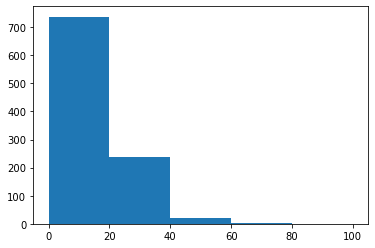

In [5]:
#embedding length

review_length = []

for review in review_list:
    review_length.append(len(review))

plt.hist(review_length, bins = [0,20,40,60,80,100]) 

In [6]:
# vocabuary size
vocabulary = []

for review in review_list:
    for word in review:
        if word not in vocabulary:
            vocabulary.append(word)
            
len(vocabulary)

2892

### Tokenization

In [7]:
keras_token = Tokenizer(oov_token = '[UNK]', lower=True)
keras_token.fit_on_texts(review_list)
word_count = keras_token.word_index

vocab_size = len(word_count)+1

print("Size of vocab:", len(word_count)+1)
list(word_count.items())[42:47]

Size of vocab: 2894


[('if', 43), ('acting', 44), ('he', 45), ('out', 46), ('his', 47)]

In [9]:
# embedding_dim = len(review_list)
embedding_dim = 100
embedding_dim

100

### Padding Process [B3]

In [10]:
sequence_train = keras_token.texts_to_sequences(review_list)
padded_train = pad_sequences(sequence_train,maxlen=100, padding='post', truncating='post')
padded_train.shape

(1000, 100)

In [11]:
padded_train[0]

array([   3,   27,   27,   27,  299,  417, 1182,   11,   37,    3, 1183,
       1184,  418,  147,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [12]:
text_idx = keras_token.sequences_to_texts(padded_train)
text_idx

['a very very very slow moving aimless movie about a distressed drifting young man [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]',
 'not sure who wa more lost the flat character or the audience nearly half of whom walked out [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]

### [B5] Preparation for Analysis. (Train Validation Test Split)

In [13]:
X = np.array(padded_train)
y = raw.is_positive.values


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15, stratify=y)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#view the training and testing sizes
print("Training Set Size: ", X_train.shape)
print("Testing Set Size: ", X_test.shape)

Training Set Size:  (750, 100)
Testing Set Size:  (250, 100)


In [14]:
# [B6] Export Datasets

X_training_df = pd.DataFrame(X_train)
X_testing_df = pd.DataFrame(X_test)
y_training_df = pd.DataFrame(y_train)
y_testing_df = pd.DataFrame(y_test)

X_training_df.to_csv('../data/capstone/X_training.csv')
X_testing_df.to_csv('../data/capstone/X_testing.csv')
y_training_df.to_csv('../data/capstone/y_training.csv')
y_testing_df.to_csv('../data/capstone/y_testing.csv')

In [15]:
texts = keras_token.sequences_to_texts(X_train)

for i in range(1000):
    print(texts[i][0:75], " : ",y_train[i]) 

but if you liked movie like the matrix and better yet their sequel i think   :  [0. 1.]
they are so easy to love but even more easy to identify with [UNK] [UNK] [U  :  [0. 1.]
judith light is one of my favorite actress and i think she doe a superb job  :  [0. 1.]
the acting a you d expect from this cast is top notch [UNK] [UNK] [UNK] [UN  :  [0. 1.]
it feature an outlandish array of memorable psychotic but lovable nut [UNK]  :  [0. 1.]
i rather enjoyed it [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [  :  [0. 1.]
the very idea of it wa lame take a minor character from a mediocre pg 13 fi  :  [1. 0.]
special mention should be made of the superb music score and sound effect w  :  [0. 1.]
the plot well i said i d let that one go [UNK] [UNK] [UNK] [UNK] [UNK] [UNK  :  [1. 0.]
first of all there are enough racial stereotype and racial joke to offend e  :  [1. 0.]
the cast wa great [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UN  :  [0. 1.]
for people who are first timer i

IndexError: list index out of range

In [16]:
print(X_train.shape)
print(y_train.shape)

(750, 100)
(750, 2)


# III Network Architecture

In [36]:
activation = 'sigmoid'
loss = 'categorical_crossentropy'
optimizer = 'adam'
num_epochs = 20

early_stopping_monitor = EarlyStopping(patience=3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1000,activation='relu'),
    tf.keras.layers.Dense(500,activation='relu'),
    tf.keras.layers.Dense(250,activation='relu'),
    tf.keras.layers.Dense(2,activation=activation)
    
])

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          289400    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1000)              101000    
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 2)                 502       
                                                        

In [37]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=num_epochs, 
                    validation_split=0.33, 
                     callbacks=[early_stopping_monitor],
                    verbose=True
                   )

Epoch 1/20
 1/16 [>.............................] - ETA: 5s - loss: 0.6941 - accuracy: 0.3750

2022-03-31 20:53:25.311388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 30ms/step - loss: 0.6981 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5081
Epoch 2/20
 4/16 [======>.......................] - ETA: 0s - loss: 0.6922 - accuracy: 0.5391

2022-03-31 20:53:25.856341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 26ms/step - loss: 0.6939 - accuracy: 0.4960 - val_loss: 0.6930 - val_accuracy: 0.5726
Epoch 3/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6938 - accuracy: 0.5080 - val_loss: 0.6933 - val_accuracy: 0.4919
Epoch 4/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6929 - accuracy: 0.5040 - val_loss: 0.6930 - val_accuracy: 0.4919
Epoch 5/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6924 - accuracy: 0.5040 - val_loss: 0.6916 - val_accuracy: 0.5282
Epoch 6/20
16/16 [==============================] - 0s 20ms/step - loss: 0.6836 - accuracy: 0.6673 - val_loss: 0.6779 - val_accuracy: 0.6895
Epoch 7/20
16/16 [==============================] - 0s 21ms/step - loss: 0.6140 - accuracy: 0.6514 - val_loss: 0.6855 - val_accuracy: 0.5484
Epoch 8/20
16/16 [==============================] - 0s 20ms/step - loss: 0.3542 - accuracy: 0.8546 - val_loss: 0.6221 - val_accuracy: 0.6855
Epoch 9/20
16/16 [======

# IV Model Evaluation

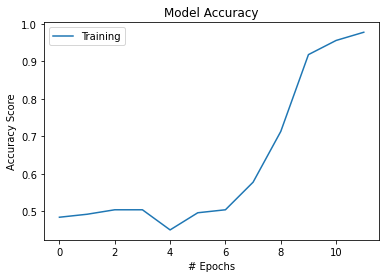

In [20]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('# Epochs')
plt.legend(['Training'], loc='upper left')
plt.show()

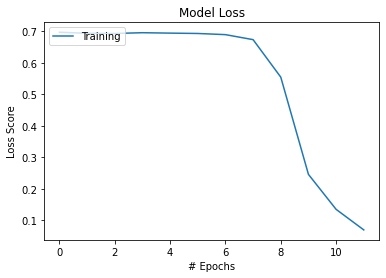

In [21]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss Score')
plt.xlabel('# Epochs')
plt.legend(['Training'], loc='upper left')
plt.show()

In [22]:
model.evaluate(x=X_test, y=y_test)

8/8 [==============================] - 0s 9ms/step - loss: 0.7048 - accuracy: 0.7640


[0.7047635316848755, 0.7640000581741333]

In [38]:
model.save('../data/capstone/sentimentModel.h5')